### Energy calibration

In [1]:
#runs on legend-base
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.utils as pgu
import pygama.analysis.peak_fitting as pgf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import calibration_jdetwiler as cb


CYCLE_0 = 2019
PEAK_DETECTION_SIGMA = 5
PEAK_DETECTION_DEGREE = 0
LOG_SCALE = True

ERROR_BAR_ON_HIST = False


title_fontsize = 20
def draw_canvas(plt, fontsize=title_fontsize, xlabel='xlabel', ylabel='count', title='title'):
    plt.figure(figsize=(20,16))
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize*1.5)
    plt.ylabel(ylabel, fontsize=fontsize*1.5)
    plt.legend(fontsize=fontsize)
    plt.title(title, fontsize=fontsize*2)

In [2]:
cycles=[2115,2121]

etype = 'trapEmax'
channel = 'ORSIS3302DecoderForEnergy/dsp'
datagroup = '/global/homes/f/fnafis/krstc/krstc.json'
known_peaks = [239.6, 351.9, 583.2, 609.32, 911.2, 1120.3, 1460.8]

N_BINS = 15000 #no of bins for trapEmax histograms
ADC_RANGE = (0,6100) #range of events with ADC values to use in making the histogram


In [3]:

def matched_peaks(bin_centers, imaxes, known_peaks, tol=5):
    matched_peaks = []
    for peak in known_peaks:
        for imax in imaxes:
            if bin_centers[imax]<peak+tol and bin_centers[imax]>peak-tol:
                matched_peaks.append(bin_centers[imax])
                #print(imax)
                break
    return matched_peaks




## Load data

loading data for /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run8_cyc2115_dsp.lh5 /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run8_cyc2116_dsp.lh5 /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run8_cyc2117_dsp.lh5 /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run8_cyc2118_dsp.lh5 /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run8_cyc2119_dsp.lh5 /global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run8_cyc2120_dsp.lh5


No handles with labels found to put in legend.



677431 events
ADC/bin:  0.407


(0.0, 6100.0)

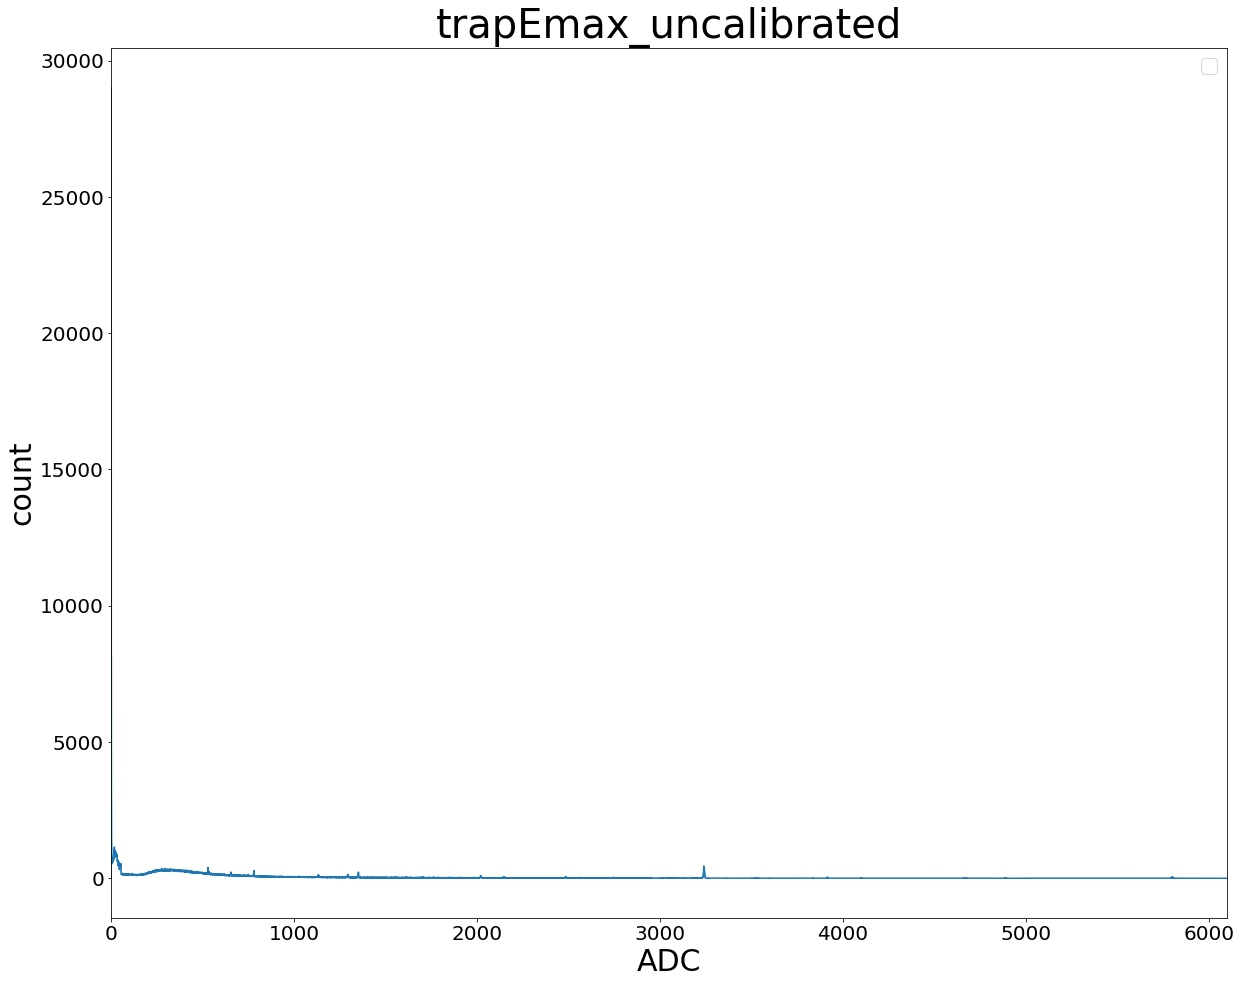

In [4]:
dg = DataGroup(datagroup, load=True)
# get file list and load energy data (numpy array)
# lh5_dir = os.path.expandvars(dg.config['lh5_dir'])
lh5_dir = dg.lh5_dir
dsp_list = lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']


dsp_list = dsp_list[cycles[0]-CYCLE_0:cycles[1]-CYCLE_0]

#edata = lh5.load_nda(dsp_list, ['trapEmax'], 'ORSIS3302DecoderForEnergy/dsp')
edata = lh5.load_nda(dsp_list, [etype], channel ) #returns a dictionary

energy_uncalibrated = edata[etype] #energy_uncalibrated


print('\n'+str(len(energy_uncalibrated)) + ' events')

n_bins = N_BINS
adc_range = ADC_RANGE



adc_per_bin = (adc_range[1]-adc_range[0])/n_bins
print('ADC/bin: ', "{:.3f}".format(adc_per_bin))

hist, bins, var = pgh.get_hist(energy_uncalibrated, bins = n_bins, 
                               range=adc_range)
draw_canvas(plt, title="trapEmax_uncalibrated", xlabel='ADC')
#pgh.plot_hist(hist, bins, var)
pgh.plot_hist(hist,bins)
plt.xlim(ADC_RANGE[0],ADC_RANGE[1])

## Finding peaks of uncalibrated energy

In [5]:
found_peaks, pars = cb.hpge_find_E_peaks(hist, bins, var, known_peaks, 
                                         deg=PEAK_DETECTION_DEGREE, 
                                         n_sigma=PEAK_DETECTION_SIGMA)

#print('pars',pars)
uncal2keV = 1/pars[0]
print('(known peaks, found peaks)')
tuple(zip(known_peaks, found_peaks))

(known peaks, found peaks)


((239.6, 530.08997),
 (351.9, 781.41003),
 (583.2, 1294.6233),
 (609.32, 1352.37),
 (911.2, 2020.9299),
 (1120.3, 2487.3767),
 (1460.8, 3241.3367))

## Fit gaussian to the top of peaks

In [6]:
GAUSSIAN_FITTING_SIGMA = 10 #how many sigma around the peak it will use to find best Gaussian fitting


def zoom_in_around(val, tolerance = 20): 
    if ERROR_BAR_ON_HIST:
        pgh.plot_hist(hist, bins,var) 
    else:
        pgh.plot_hist(hist,bins)
        #plt.ylim(0.1,1.1*np.amax(hist))
    #if markers: plt.plot(bin_centers[imaxes], hist[imaxes], lw=0, marker='v')
    if LOG_SCALE: plt.yscale('log')

    plt.xlim(val-tolerance,val+tolerance)
    return None


def plot_gaussian_at_peak(i, plt, pt_pars, zoom_in_tolerance=30):
    peak = found_peaks[i]
    zoom_in_around(peak, tolerance=zoom_in_tolerance)
    plt.ylim(0,25*pt_pars[i,2])
    pgu.plot_func(pgf.gauss_basic, pt_pars[i],
                 range=(peak-0.5*GAUSSIAN_FITTING_SIGMA*adc_per_bin,peak+0.5*GAUSSIAN_FITTING_SIGMA*adc_per_bin))
    plt.title('poisson LL='+str(poissonLL[2])+', fit range='+str(GAUSSIAN_FITTING_SIGMA) +
              '\n[$\mu$, $\sigma$, A]='+str(pt_pars[i])+'\n found peak='+str(found_peaks[i]),
             fontsize=title_fontsize)
    plt.show()
    return None



'''
pt_pars: a list of best-fit parameters (mode=mu, sigma, max=amplitude) for 
each peak-top fit pt_covs: a list of covariance matrices for each pars
'''

poissonLL = []
for i in range(len(found_peaks)): poissonLL.append(False)


pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, found_peaks, poissonLL,
                                           n_to_fit=GAUSSIAN_FITTING_SIGMA)
mu1s = pt_pars[:,0]

pt_pars, pt_covs = cb.hpge_fit_E_peak_tops(hist, bins, var, mu1s, poissonLL,
                                           n_to_fit=GAUSSIAN_FITTING_SIGMA)

mus_final = pt_pars[:,0]

#sigmas_final = pt_pars[:,1]


for i in range(len(mu1s)):
    draw_canvas(plt, xlabel='ADC')
    plot_gaussian_at_peak(i, plt, pt_pars, zoom_in_tolerance=15)


/global/u2/f/fnafis/krstc/calibration_jdetwiler.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pars_list), np.array(cov_list)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Scipy's curve_fit fitting for x=$\mu$, y=known peaks)

In [ ]:
ADC_TO_KEV_FIT_DEGREE = 1 #1:linear, 2:quadratic etc.
mu_vars = pt_covs[:,0,0]

inv_pars, inv_covs = cb.hpge_fit_E_scale(mus_final, mu_vars, known_peaks, deg=ADC_TO_KEV_FIT_DEGREE)

pars, covs = cb.hpge_fit_E_cal_func(mus_final, mu_vars, known_peaks, inv_pars, deg=ADC_TO_KEV_FIT_DEGREE)
print('pars: ', pars)

## calibrated histogram

In [ ]:
energy_calibrated = np.polyval(pars, energy_uncalibrated)
KEV_RANGE = np.polyval(pars, ADC_RANGE)


hist_calibrated, bins_calibrated, var_calibrated = pgh.get_hist(energy_calibrated, bins=n_bins)

draw_canvas(plt, xlabel='trapEmax_calibrated (KeV)')
pgh.plot_hist(hist_calibrated, bins_calibrated, lw=1)
if LOG_SCALE: plt.yscale('log')


peak_list = pd.read_csv('peak_list.txt', delimiter=' ')
peak_list_tall = peak_list[peak_list.iloc[:,2]=='T']
#peak_list = peak_list_tall   #If one wants to see only tall peaks
#T=Tall means yes you might be able to calibrate with this

colors = ['b','g','r','c','y','m','k','maroon','dodgerblue','darkgoldenrod', 'gold',
         'darkslategray', 'orange']
color_index=0
for i in range(peak_list.shape[0]):
    label = ''
    if peak_list.iloc[i,1]<KEV_RANGE[1] and peak_list.iloc[i,1]>KEV_RANGE[0]:
        is_tall_label=''
        if peak_list.iloc[i,2]=='T': is_tall_label=' T'
        label = peak_list.iloc[i,0]+'='+str(peak_list.iloc[i,1])+is_tall_label
    plt.axvline(x=peak_list.iloc[i,1], label=label, 
                    color=colors[color_index%12], ls='--', lw=2)
    color_index+=1

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=title_fontsize)

plt.xlim(KEV_RANGE[0],KEV_RANGE[1])



mus_final_calibrated = np.polyval(pars, mus_final)
discrepancy = (known_peaks-mus_final_calibrated)/known_peaks*100
result_tup = {'Known peaks(keV)':known_peaks,
              'Uncalibrated peaks (ADC)':mus_final,
              'Calibrated peaks(keV)':mus_final_calibrated,
              'Discrepancy(%)':discrepancy}
print('pars: ',pars)
pd.DataFrame(result_tup)


## Error Analysis

In [ ]:
known_peaks_calibrated = np.polyval(pars, mus_final)
residuals = (known_peaks-known_peaks_calibrated)
result_tup = {'Known peaks(keV)':known_peaks,
       'Calibrated peaks(keV)':known_peaks_calibrated,
       'Residual (keV)':residuals}

errors = np.sqrt(pt_covs[:,0,0])
draw_canvas(plt, title='Residuals between known and calibrated peaks', 
           xlabel='trapEmax_cal (keV)')
plt.errorbar(known_peaks, residuals, fmt='o', yerr=errors)
plt.axhline(0)

pd.DataFrame(result_tup)
